In [ ]:
!pip install higra

import numpy as np
import higra as hg
import torch as tc
from skimage import data
from imageio import imread, imwrite
%matplotlib inline
import matplotlib.pyplot as plt

import urllib.request as request; exec(request.urlopen('https://perso.esiee.fr/~perretb/tutoDGMM/helper.py').read(), globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 12.6 MB/s 


# Component trees

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

This tutorial will show you how hierarchical methods can be used to filter and analyse vertex valued graphs. It is composed of three parts:

1. The first part reviews the notion of component trees and shows how those hierarchical representations can be used to define and compute connected filters.
2. The second part shows how component trees can be used for defining topological losses usable in a continuous optimization context.
3. The third part demonstrates the shaping method, where a component tree is filtered by contructing a new component tree over the first tree: it's the tree-ception!

# 1. Connected image filtering with component trees



## Connected operators and component trees

Connected operators are functions which solely act by removing connected components frm the level sets of an image.
By doing so, connected operators:

- never creates or moves contours: contours can only be removed;
- can use region features such as topologic, geometric or texture charachetistics in order to select which components should be preserved or removed.

The design and the efficient computation of connected operators often rely on  hierarchical representations called component trees:

- the max tree represents the connected components of the upper level sets of the image, it is thus oriented toward maxima;
- the min tree represents the connected components of the lower level sets of the image, it is thus oriented toward minima;
- the tree of shapes represents the connected components of both lower and upper level sets of the image.

### Toy example

Let's see how the max tree works on a very simple grayscale image of size 5*5

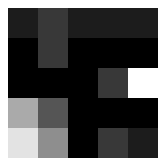

In [ ]:
image = np.asarray([[1, 2, 1, 1, 1],
                    [0, 2, 0, 0, 0],
                    [0, 0, 0, 2, 9],
                    [6, 3, 0, 0, 0],
                    [8, 5, 0, 2, 1]])

imshow(image,cmap='gray', figsize=(100,100));

The max tree is build from the connected components of the upper level sets of the image which are shown below:

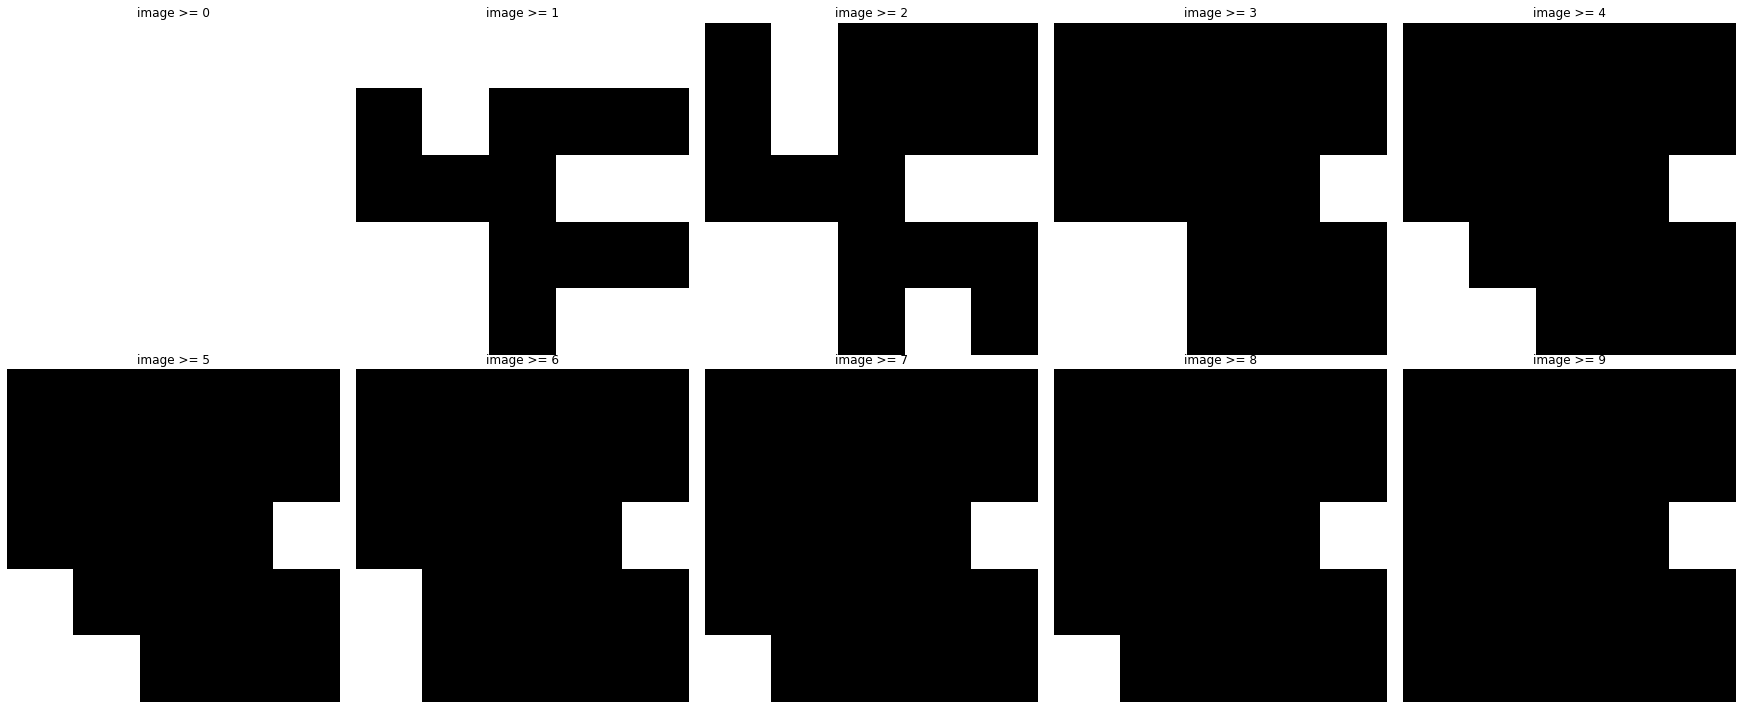

In [ ]:
fig = plt.figure(figsize=(5 * 5, 2 * 5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i in range(0,10):
    plt.subplot(2, 5, (i//5)*5 + i%5 + 1)
    plt.imshow(image>=i, interpolation='none', cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title("image >= " +str(i))


In this case, the 1-upper level set has 4 connected components, the 2-upper lever set has also 4, the third has only 2 and so on. Then, each connected component is reprensented by a node in the max tree and the parent-child relation corresponds to the inclusion relation between connected components.

#### Max tree construction

To compute the max tree of this image with Higra, we need to have a graph where nodes represent pixels and edges are the adjacency relation between pixels. Pixels values are then weights associated to each node of the graph.

In [ ]:
g = hg.get_4_adjacency_implicit_graph(image.shape)

tree, altitudes = hg.component_tree_max_tree(g, vertex_weights=image)

We can check the result of the tree computation. Here we have a simple ascii print of the tree.
The leaves on the left are the graph nodes (ie. the pixels of the image) ordered by raster scan. 
Then each internal node of the tree is represented by a value, its altitude, along a branch saying at which level it appeared in the upper level sets of the image.

For example, at the very bottom of the tree, we have pixels 1 and 6 that formed a connected component in the 2-upper level set of the image. 

In [ ]:
print_max_tree(tree, altitudes)

 5------------------------------------------------------------------
                                                                   |
                                                                   |
                                                                   |
 7------------------------------------------------------------------
                                                                   |
                                                                   |
                                                                   |
 8------------------------------------------------------------------
                                                                   |
                                                                   |
                                                                   |
 9------------------------------------------------------------------
                                                                   |
                                  

#### Max tree filtering

Once the max tree representing an image is computed, one can perform a filtering of this tree, guided by an attribute value, using the following steps:

- compute an attribute for each node of the tree; 
- compute which node has to be removed/kept depending on the attribute values; 
- remove the unwanted nodes from the tree; and
- reconstruct an image using the simplified tree.

Here we will perform an area filter removing all components whose size is smaller or equal than 3.

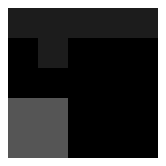

In [ ]:

area = hg.attribute_area(tree) # compute the area of each node, ie the number of leaves below each node
deleted_nodes = area <= 3      # an attribute is a simple numpy array, it can be maninpulated with vectorized operators
                               # deleted_nodes is a new node attributes with boolean values indicating if a node should
                               # be deleted or kept
new_tree, node_map = hg.simplify_tree(tree, deleted_nodes) # remove all nodes marked as deleted
                                                           # node_map indicates for each node of new_tree the index of the 
                                                           # corresponding node in tree
new_altitudes = altitudes[node_map]    # take the altitudes of the non deleted nodes
new_image = hg.reconstruct_leaf_data(new_tree, new_altitudes) # reconstruct an image from the filtered tree

imshow(new_image, cmap='gray', figsize=(100,100), vmin=0, vmax=9);

The regional maxima of size lower than or equal to 3 have been erased.

## Exercise - Cell segmentation

The input image represents a slice of a cell. In order to know whether this cell is sane or not, it is important to perform a geometrical analysis of the visible bright lobes. In order to perform such analysis, one usually starts by finding the spatial extension of these bright lobes. The aim is to extract the bright lobes of the image.


|                         *Input*                                                   |                         *Excepted result*                        |
|:---------------------------------------------------------------------------------:|:----------------------------------------------------------------:|
| <img src="https://www.esiee.fr/~perretb/MM/fig/cil.png" style="width: 300px;"/> | <img src="https://www.esiee.fr/~perretb/MM/fig/cilSeg.png" style="width: 300px;"/>    

The following functions can be useful:

- [hg.get_4_adjacency_implicit_graph](https://higra.readthedocs.io/en/latest/python/graph_image.html#higra.get_4_adjacency_implicit_graph)
- [hg.component_tree_max_tree](https://higra.readthedocs.io/en/latest/python/component_tree.html#higra.component_tree_max_tree)
- [hg.attribute_area](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_area)
- [hg.attribute_volume](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_volume)
- [hg.attribute_height](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_height)
- [hg.attribute_extrema](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_extrema)
- [hg.simplify_tree](https://higra.readthedocs.io/en/latest/python/hierarchy_core.html#higra.simplify_tree)
- [hg.reconstruct_leaf_data](https://higra.readthedocs.io/en/latest/python/tree_algorithm.html#higra.reconstruct_leaf_data)

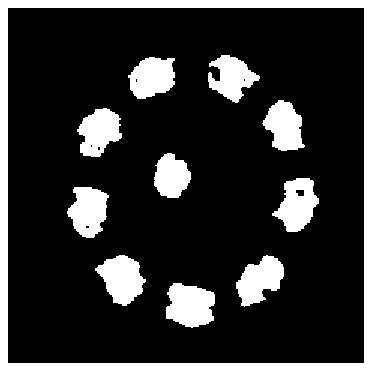

In [ ]:
image = imread("https://perso.esiee.fr/~perretb/MM/ex6/cil.pgm") / 255

###  YOUR CODE HERE  ###
graph = hg.get_4_adjacency_implicit_graph(image.shape)
tree, altitudes = hg.component_tree_max_tree(graph, image)
volume = hg.attribute_volume(tree, altitudes)

tree, node_map = hg.simplify_tree(tree, volume < 50)
altitudes = altitudes[node_map]
extr = hg.attribute_extrema(tree, altitudes)

res = hg.reconstruct_leaf_data(tree, extr)

### END OF YOUR CODE ###

imshow(res, cmap='gray');

## Exercise - Galaxy analysis

The input image represents the spiral galaxy M51. Spiral galaxies are characterized by the presence of spiral arms which are regions of higher stars and dust density. Among those arms lye particular regions, called HII regions, where new stars are created. HII regions are the only places where massive young stars, which are very bright and short lived, can be found. HII regions are characterized by their blueish color (produced by the young massive stars) and their relatively small size. The goal of this exercise is to detect HII regions in the input image.


|                         *Input*                                                   |                         *Excepted result*                                              |
|:---------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------:|
| <img src="https://www.esiee.fr/~perretb/MM/fig/m51.png" style="width: 450px;"/>   | <img src="https://www.esiee.fr/~perretb/MM/fig/m51Seg.png" style="width: 450px;"/>     |

Note that this time, the input image is a colour image. However, we do not know how to compute a max-tree of a colour image. While more sofisticated solutions exist, a simple approach in this case is simply to convert the input image to grayscale. The input color image will then be used to compute the color of each component of the grayscale max-tree. 

Formally, the HII regions can be characterized with the following feature:

- their area is not too small to avoid noise;
- their area is not too large to avoid large scale structures; and
- their color is blue. Note that, to measure the blueness of an object in astronomy we usually consider the difference between the blue channel and the green channel: the larger the difference the bluer it is. 


The following functions can be useful:

- [hg.get_4_adjacency_graph](https://higra.readthedocs.io/en/latest/python/graph_image.html#higra.get_4_adjacency_graph)
- [hg.component_tree_max_tree](https://higra.readthedocs.io/en/latest/python/component_tree.html#higra.component_tree_max_tree)
- [hg.attribute_area](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_area)
- [hg.attribute_mean_vertex_weights](https://higra.readthedocs.io/en/latest/python/tree_attributes.html#higra.attribute_mean_vertex_weights)
- [hg.simplify_tree](https://higra.readthedocs.io/en/latest/python/hierarchy_core.html#higra.simplify_tree)
- [hg.reconstruct_leaf_data](https://higra.readthedocs.io/en/latest/python/tree_algorithm.html#higra.reconstruct_leaf_data)

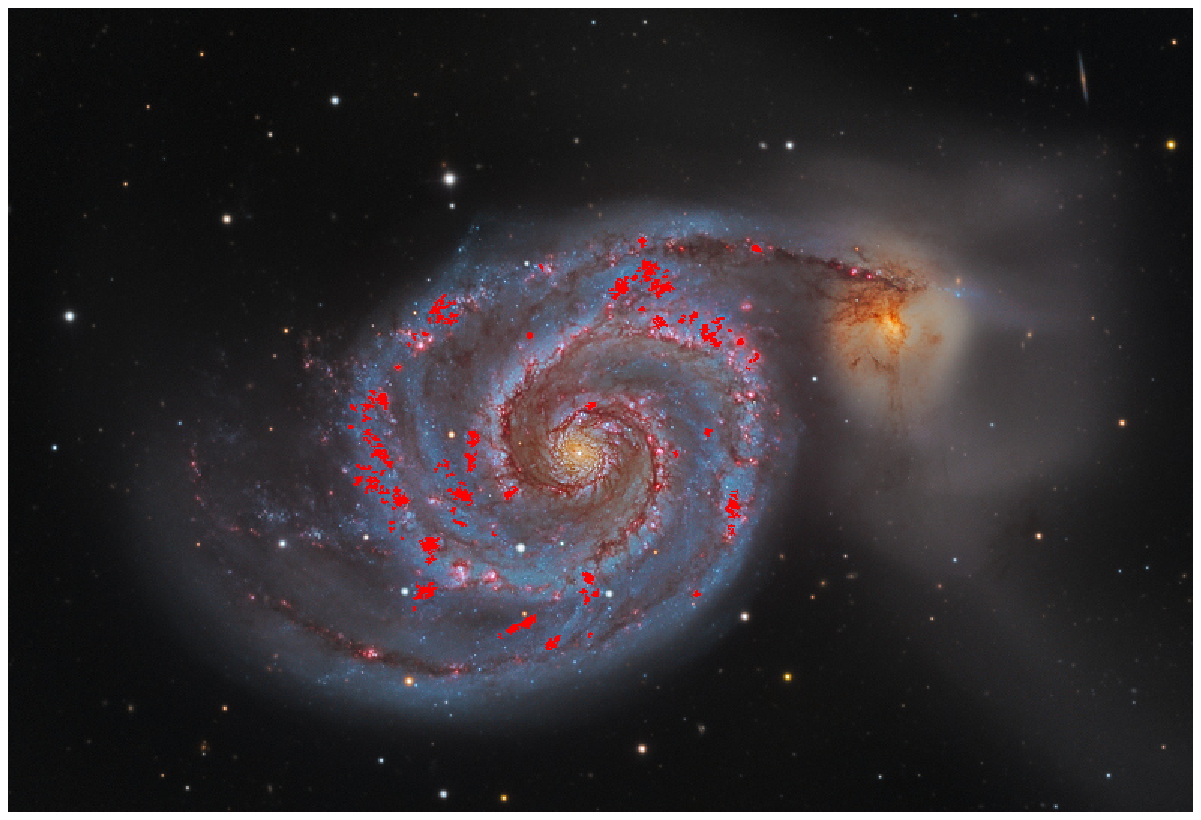

In [ ]:
image_color = imread("https://www.esiee.fr/~perretb/MM/fig/m51.png") / 255

# greyscale image and normalization
image = np.mean(image_color, axis=2)
image = image - image.min()

###  YOUR CODE HERE  ###

graph = hg.get_4_adjacency_implicit_graph(image.shape[:2])
tree, altitudes = hg.component_tree_max_tree(graph, image)
blueish = image_color[:,:,2] - image_color[:,:,1]
area = hg.attribute_area(tree)
blueish = hg.attribute_mean_vertex_weights(tree, blueish)

cond = np.logical_or(np.logical_or(area<5, area>100), blueish < 0.15)
res = hg.reconstruct_leaf_data(tree, altitudes, cond)
### END OF YOUR CODE ###

# detected regions will be displayed in red above the original image
res = (res > 0).astype(np.float64)
im = np.copy(image_color)
im[res > 0] = [1,0,0] 
imshow(im);

# 2. Topological loss functions with component trees

Component trees are based on the decomposition of the level sets of a vertex valued graph into connected components. Each connected component is associated to an altitude which is equal to the level of the first level set where the component appears. The altitude of a component is thus equal to the value of some vertices of the graph. We can then back-propagate a modification of the tree altitudes to the original vertex values.   

The following functions implement component-trees (max-tree, min-tree, and tree-of-shapes) as Pytorch functions where the altitudes of the tree are differentiable with respect to the vertex values of the input graph.

In [ ]:
class MaxTreeFunction(tc.autograd.Function):
    @staticmethod
    def forward(ctx, graph, vertex_weights):
        """
        Construct a max tree of the given vertex weighted graph.

        return: the altitudes of the tree (torch tensor), the tree itself is stored as an attribute of the tensor
        """ 
        
        tree, altitudes = hg.component_tree_max_tree(graph, vertex_weights.detach().numpy())
        altitudes = tc.tensor(altitudes).requires_grad_(True)
        
        ctx.saved = (tree, graph)
        # torch function can only return tensors, so we hide the tree as an attribute of altitudes
        altitudes.tree = tree
        return altitudes

    @staticmethod
    def backward(ctx, grad_output):
        tree, graph = ctx.saved
        
        # gradient on the vertex_weight is equal to the gradient on the altitude of the parent node
        grad_in = grad_output[tree.parents()[:tree.num_leaves()]]
       
        return None, hg.delinearize_vertex_weights(grad_in, graph), None

class MaxTree(tc.nn.Module):
    def __init__(self):
        super().__init__()
       
    def forward(self, graph, vertex_weights):
        altitudes = MaxTreeFunction.apply(graph, vertex_weights)
        return altitudes.tree, altitudes

max_tree = MaxTree()

## Maxima selection loss

In the following, our objective is to define loss functions that can *select* a given number of maxima and *remove* the others. The maxima are characterized by their dynamics, ie, the altitude difference between the top of the maximum and the altitude of the saddle node associated to this maximum (the saddle node is the closest node that enable to reach a deeper maximum). The dynamics is also called the topological persistence. Assume that the given contains $\ell$ maxima $\{M_1,\ldots,M_\ell\}$ sorted by descending value of dynamics. The maxima selection loss is defined as:

$$loss_{max}(I;k,p,q) = -\sum_{i=1}^{i\leq k} dyn(M_i)^p + \sum_{i=k+1}^{i\leq \ell} dyn(M_i)^q $$

where:

- $k$ is the target number of maxima;
- $dyn(M_i)$ denotes the dynamcis of the maxima $M_i$;
- $p$ and $p$ are two positive numbers controlling the contribution of each term.

A possible implementation of this loss function is given bellow:

In [ ]:
def loss_maxima_dynamics(graph, image, num_target_maxima, p=1, q=2):
    """
    Loss that favors the presence of num_target_maxima in the given image. 
    """
    tree, altitudes = max_tree(graph, image)
    altitudes_np = altitudes.detach().numpy()

    # find the position of the extrema and their altitudes
    extrema = hg.attribute_extrema(tree, altitudes_np)
    extrema_indices = np.arange(tree.num_vertices(), dtype=np.int64)[extrema]
    extrema_altitudes = altitudes[tc.from_numpy(extrema_indices)]

    # computes the dynamics associated to each maximum, 
    depth = attribute_depth(tree, altitudes_np)
    saddle_nodes = tc.from_numpy(attribute_saddle_nodes(tree, depth)[0])
    extrema_dynamics = extrema_altitudes - altitudes[saddle_nodes[extrema_indices]]

    extrema_dynamics, _ = tc.sort(extrema_dynamics, descending=True)
    if len(extrema_dynamics) <= num_target_maxima:
        return -tc.sum(extrema_dynamics**p)
    else:
        return -tc.sum(extrema_dynamics[:num_target_maxima]**p) + tc.sum(extrema_dynamics[num_target_maxima:]**q)

Let's see how this works on a simple demonstration image. This image contains 4 blob like maxima and we will try to use the proposed loss function to keep only two maxima.

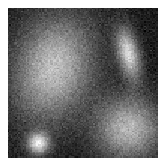

In [ ]:
image = imread("https://perso.esiee.fr/~perretb/tutoDGMM/multi_max_noisy.tiff")
graph = hg.get_4_adjacency_implicit_graph(image.shape)
imshow(image, cmap="gray");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


Iteration 0: Loss: 2.7953, LR: 0.001
Iteration 300: Loss: -1.6453, LR: 0.001
Iteration 600: Loss: -1.7588, LR: 0.001
Iteration 900: Loss: -1.8278, LR: 0.001
Iteration 1200: Loss: -1.8734, LR: 0.001
Iteration 1500: Loss: -1.9088, LR: 0.001
Iteration 1800: Loss: -1.9384, LR: 0.001
Iteration 2100: Loss: -1.9657, LR: 0.001
Iteration 2400: Loss: -1.9918, LR: 0.001
Iteration 2700: Loss: -1.9998, LR: 0.001


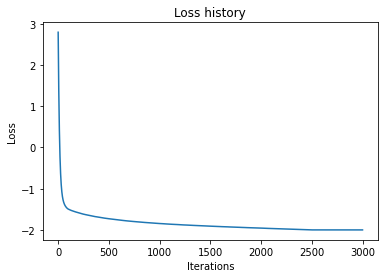

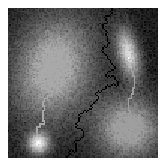

In [ ]:
# target for 2 maxima
loss = lambda image: loss_maxima_dynamics(graph, image, num_target_maxima=2, p=1, q=2)

# Optimizer is a little helper class to perform the gradient descent
opt = Optimizer(loss, lr=0.001)
res = opt.fit(tc.from_numpy(image.copy()), iter=3000, debug=300)
opt.show_history()
imshow(res.detach().numpy(), cmap="gray");

## Exercise: Neurite image filtering

The following example demonstrates how the loss function loss_maxima can be combined with a classical data fidelity term (L2 loss) and a classical regularization term (TV2 loss) to perform image filtering. 

Let's consider a bit more complex case. The following image shows a dendrite of a neurite used in toxicological essays. 
The dendrite is normally connected, but due to projection effects and imaging artifacts it appears disconnected. The goal is then to reconnect the dendrite. 

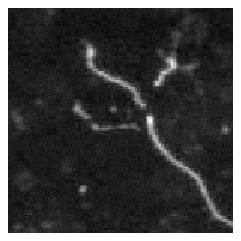

In [ ]:
image = tc.from_numpy(imread("https://perso.esiee.fr/~perretb/tutoDGMM/neurite_crop.tiff"))
graph = hg.get_4_adjacency_implicit_graph(image.shape)
imshow(image, cmap="gray");

### Question 1: reconstruction of the neurite image

In order to recosntruct the dendrite we will optimize a loss function combining 3 terms:

1. A L2 loss: this data attachment term says that the reconstructed image should stay close to the original image;
2. A maxima selection loss: this term says that the reconstructed image should contain a single maximum;
3. A TV2 loss: this term says that the reconstructed image should be smooth.


This can be written as 
$$loss(I) = ||I - y||_2^2 +  \lambda_1 loss_{max}(I; 1,1,1) + \lambda_2 ||\nabla I||_2^2$$

where $y$ is the original image.

Question: implement the proposed loss and optimize it. Expected result (something like...):


<img src="neurite_res.png"/>     

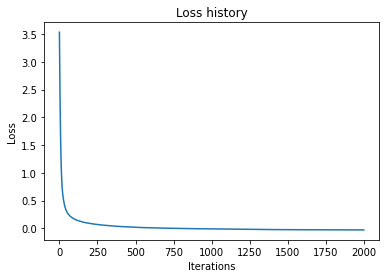

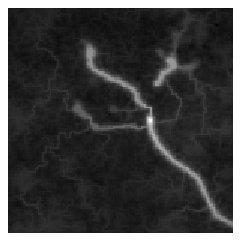

In [ ]:

# helper functions
def loss_l2(image, observation):
    """
    l2 loss function: mean((image - observation)**2)
    """
    return tc.mean((image - observation)**2)

def loss_tv(image, p=2):
    """
    TV-p regularization: mean of the partial derivatives ** p
    """
    return tc.mean(tc.abs(image[:,1:] - image[:,:-1])**p) + tc.mean(tc.abs(image[1:,:] - image[:-1,:])**p)


###  YOUR CODE HERE  ###

def loss(im):
    l = (loss_l2(im, image) + 
       0.05 * loss_maxima_dynamics(graph, im, num_target_maxima=1,  p=1, q=1) +
       0.5 * loss_tv(im, 2))
    return l


opt = Optimizer(loss, lr=0.001)
opt.fit(image.clone(), iter=2000)
opt.show_history()
imshow(opt.best.detach().numpy(), cmap="gray");

### END OF YOUR CODE ###



### Question 2: reconstruction of the neurite image v2

In the previous question we have successfully reconstructed a connected neurite (some reconstruction choices could be discussed :) ). However, the bridges added between disconnected parts are very thin and not realistic. 
Can you propose modifications of your previous loss function in order to avoid this problem? 
To help you, we provide a pytorch implementation of a morphological erosion/dilation below. 

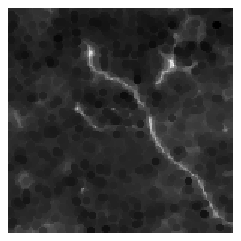

In [ ]:
def morpho(image, kernel, operation):
    """
    Quick implementation of morphological dilation and erosion in pytorch.
    
    Image must be a 2d torch array with values in [0,1] (requires_grad is supported).
    Kernel must be a 2d binary mask.
    Operation can be either "dilate" or "erode".
    
    This implementation is not very efficient and has a sparse gradient (ie. this is not SOTA :) )
    """
    import torch.nn.functional as F

    p1 = kernel.shape[0] // 2
    p2 = kernel.shape[1] // 2
    im = image.reshape([1, 1, *image.shape])

    k = kernel.reshape((1, -1, 1))

    if operation == 'dilate':
        im = F.pad(im, ((p1, p1, p2, p2)), mode='constant', value=0)
        folds = F.unfold(im, kernel.shape)
        k = (1 - k) * -9999999999
        folds_proc, _ = tc.max(folds + k, axis=1)
    elif operation == 'erode':
        im = F.pad(im, ((p1, p1, p2, p2)), mode='constant', value=1)
        folds = F.unfold(im, kernel.shape)
        k = (1 - k) * 9999999999
        folds_proc, _ = tc.min(folds + k, axis=1)

    else:
        raise ValueError("Unsupported operation " + operation)

    return folds_proc.reshape(image.shape)


# Usage example
kernel = tc.as_tensor([[0,1,1,1,0],
                       [1,1,1,1,1],
                       [1,1,1,1,1],
                       [1,1,1,1,1],
                       [0,1,1,1,0]])

imshow(morpho(image, kernel, "erode"), cmap="gray");

Question: propose a new loss function  for reconstructing the neurite with thick bridges and optimize it:

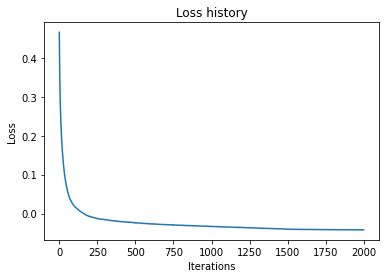

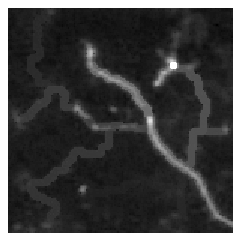

In [ ]:
###  YOUR CODE HERE  ###

def loss(im):
    l = (loss_l2(im, image) + 
       0.05 * loss_maxima_dynamics(graph, morpho(im,kernel, "erode"), num_target_maxima=1,  p=1, q=1) +
       0.5 * loss_tv(im, 2))
    return l

project = lambda image: tc.clamp(image, min=0, max=1)

opt = Optimizer(loss, lr=0.001)
opt.fit(image.clone(), iter=2000)
opt.show_history()
imshow(opt.best.detach().numpy(), cmap="gray");

### END OF YOUR CODE ###

# Robust tree filtering - The shaping framework

In the previous examples we filtered a max tree with a simple thresholding of an attribute. Thresholding is a simple approach but it is not robust to noise. In this example we will see a more complex and robust approach called the shaping framework. In this approach the tree and its attribute are considered as a new weighted graph whose vertex represent shapes (connected components) in the original images and whose adjacency relation corresponds to the parent-child relation in the tree. This new weighted graph can then be processed by a connected operator. This method was first presented in the following article:

> Yongchao Xu, Thierry Géraud, Laurent Najman. Connected Filtering on Tree-Based Shape-Spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence, Institute of Electrical and Electronics Engineers, 2016, 38 (6), pp.1126 - 1140. [⟨10.1109/TPAMI.2015.2441070](https://dx.doi.org/10.1109/TPAMI.2015.2441070)⟩. [⟨hal-01162437⟩](https://hal.archives-ouvertes.fr/hal-01162437)




In the following, we are going to keep the "most circular objects" in an image, and remove the rest.

The principle is the following: we first build a max tree that contains all the connected components of the upper level sets of the image. Then we assess how circular those components are, using a circularity criterion. We then transform the max tree into a graph, each node of the max tree having as neighbors in the graph its parent and its children. We then weight the nodes on the graph with the circularity criterion. Finally, we compute a min-tree of the weighted graph, and filter the graph by removing the less cicular nodes. Reconstructing an image from the preserved nodes of the graph provides the result. This is illustrated in the following figure.

<img src="http://laurentnajman.org/uploads/images/new_shema.png" alt="Shaping explaination" width="400" margin="auto" />

Let us take a simple image, which contains coins.

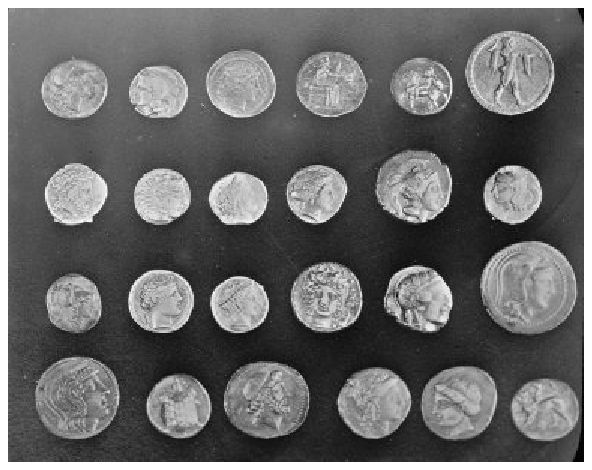

In [ ]:
image = data.coins()

# discard the color channel (if any)
size = image.shape[:2]
imshow(image, cmap='gray');

### Initial max tree construction

We first construct the max tree of the image and perform an area filter to decrease the number of nodes:

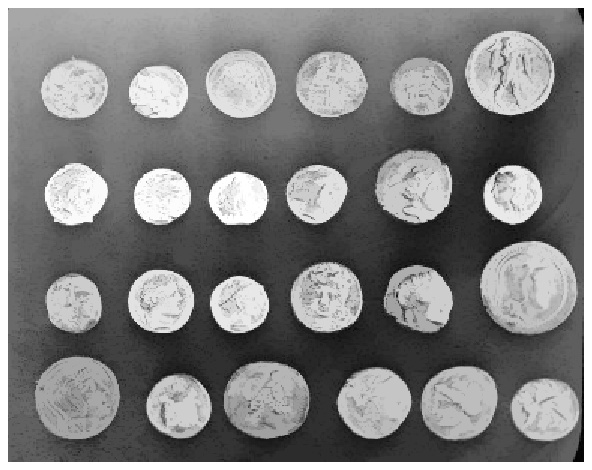

In [ ]:
#Build the max tree
graph = hg.get_4_adjacency_implicit_graph(size)
tree1 , altitudes1 = hg.component_tree_max_tree(graph, image)

#Remove small components
# This is done mostly for obtaining a simpler tree, the results will not change if we do not do that
area = hg.attribute_area(tree1)
deleted_nodes = area < 500
tree1 , node_map = hg.simplify_tree(tree1, deleted_nodes)
altitudes1 = altitudes1[node_map]


# show equivalent filtered image
filtered_image = hg.reconstruct_leaf_data(tree1, altitudes1)
imshow(filtered_image, cmap='gray');

### Circularity attribute

To assess the circularity of a connected component we compute the ratio its major and minor axes lengths estimated by the eigenvalues of its covariance matrix (see image moments in [Wikipedia](https://en.wikipedia.org/wiki/Image_moment)). 

There is not predefined function that computes this attribute in Higra. However, it still can be computed efficiently thanks to generic accumulators and vectorized operations. 
Here we use the [sequential accumulator](https://higra.readthedocs.io/en/stable/tree.html#sequential-accumulator) which defines the new value of a node as the accumulation of the accumulated values of its children.

In [ ]:
#Circularity is 1 for a disk and tends toward 0 for non disk like shapes
def circularity(tree, size):
    emb = hg.EmbeddingGrid2d(tree.leaf_graph.shape)      # utility object to deal with point on a  subset of the Z^2 grid                          
    coord = emb.lin2grid(np.arange(tree.num_leaves()))   # generate coordinates of the points corresponding to the 
                                                         # vertices of the iamge graph

    m = np.zeros((tree.num_leaves(), 6), dtype=np.float64) # compute the raw moments up to order 2 on the pixels
    m[:, 0] = 1
    m[:, 1] = coord[:, 0]
    m[:, 2] = coord[:, 1]
    m[:, 3] = coord[:, 0] * coord[:, 1]
    m[:, 4] = coord[:, 0] * coord[:, 0]
    m[:, 5] = coord[:, 1] * coord[:, 1]

    m = hg.accumulate_sequential(tree, m, hg.Accumulators.sum) # recursively computes the raw moments on the whole tree
    m00 = m[:, 0]                                              # unpack the different moments
    m10 = m[:, 1]
    m01 = m[:, 2]
    m11 = m[:, 3]
    m20 = m[:, 4]
    m02 = m[:, 5]

    xmean = m10 / m00                                          # compute mean, variance, covariance, eigenvalues  (lambda1/2)
    ymean = m01 / m00
    xvar = m20 / m00 - xmean * xmean
    yvar = m02 / m00 - ymean * ymean
    xycovar = m11 / m00 - xmean*ymean
    lambda1 = np.maximum(0, 0.5 * (xvar + yvar + np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
    lambda2 = np.maximum(0, 0.5 * (xvar + yvar - np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))

    # return ratio of the eigenvalues
    return np.nan_to_num(lambda2[tree.num_leaves():] / lambda1[tree.num_leaves():])

circ = circularity(tree1, size)

## Shape space graph building

Now, your turn.

First, you need to transfrom the nodes of the max-tree into a graph (do not consider the pixels, ie, the leaves of the tree.

You need to create a graph ``graph2`` with the nodes of ``tree1``, and add the edges of ``tree1`` (except those involving a leaf node) to ``graph2``.

Useful functions:

- [hg.UndirectedGraph](https://higra.readthedocs.io/en/stable/python/UndirectedGraph.html#higra.UndirectedGraph.__init__)
- [UndirectedGraph.add_edges](https://higra.readthedocs.io/en/stable/python/UndirectedGraph.html#higra.UndirectedGraph.add_edges)
- [Tree.edge_list](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.edge_list)
- [Tree.num_leaves](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.num_leaves)
- [Tree.num_vertices](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.num_vertices)

In [ ]:
graph2 = None
###  YOUR CODE HERE  ###
graph2 = hg.UndirectedGraph(tree1.num_vertices() - tree1.num_leaves()) # graph whose vertices are the internal nodes of
                                                                       # the max tree

sources, targets = tree1.edge_list()                                   # list of all parent-child relation in the max-tree

graph2.add_edges(sources[tree1.num_leaves():] - tree1.num_leaves(),    # remove edges between non internal nodes
                 targets[tree1.num_leaves():] - tree1.num_leaves())
### END OF YOUR CODE ###

assert graph2.num_edges()==tree1.num_vertices() - tree1.num_leaves() - 1, "This does not seem right ヽ(ಠ_ಠ)ノ"

## Shape space filtering

Now, we want to remove the components whose circularity is too small, meaning that we are indeed interested about
the minima of the shape space: we will thus construct the min tree instead of max tree.
The relevance of a minimum in this min tree will be assessed by its height.

So, compute ``tree2``, a min-tree of ``graph2`` with respect to the circularity attributes stored in ``circ``. Then, compute the height of the nodes of ``tree2``. Finally, determine which nodes are not circular enough: we will say that any node whose height (for the circularity attribute) is lower than 0.75 does not represent a sufficiently circular shape.

Useful functions:

- [hg.component_tree_min_tree](https://higra.readthedocs.io/en/stable/python/component_tree.html#higra.component_tree_min_tree)
- [hg.attribute_height](https://higra.readthedocs.io/en/stable/python/tree_attributes.html#higra.attribute_height)

In [ ]:
###  YOUR CODE HERE  ###
# Compute the min tree
tree2, altitudes2 = hg.component_tree_min_tree(graph2, circ)   

# Compute the height of the basin of graph2
height =  hg.attribute_height(tree2, altitudes2)   

# Determine which nodes have a height smaller than 0.75
deleted_nodes_tree2 = height < 0.75
### END OF YOUR CODE ###

assert deleted_nodes_tree2.shape == (4446,), "This does not seem right ＼(｀0´)／"
assert deleted_nodes_tree2.sum() == 4182, "This does not seem right ಠ_ರೃ"

## Transferring filtering to tree1

Now, things become a bit tricky because we know the nodes of ``tree2`` which are not enough circular and 
we need to go back to ``tree1``. Remember that the internal nodes of ``tree1`` are in bijection with the leaves of ``tree2``. We will thus determine the leaves of ``tree2`` belonging to deleted nodes in the shape space.

Now we are going to remove the nodes of ``tree2`` which are not relevant (height is too low), and reconstruct an image from the filtered ``tree1``.

Useful functions:

- [Tree.parents](https://higra.readthedocs.io/en/stable/python/TreeGraph.html#higra.Tree.parents)
- [hg.reconstruct_leaf_data](https://higra.readthedocs.io/en/stable/python/tree_algorithm.html#higra.reconstruct_leaf_data)
- [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)

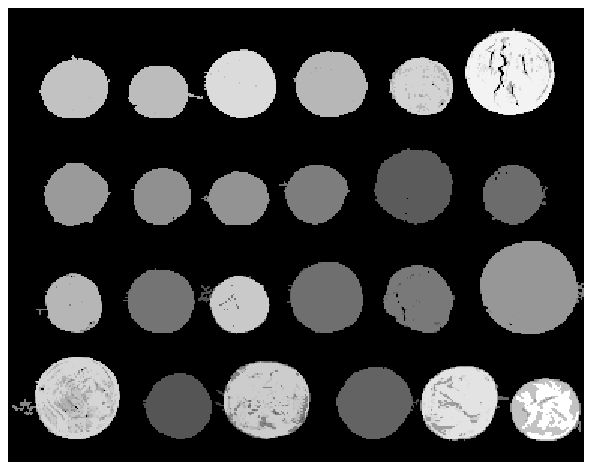

In [ ]:
###  YOUR CODE HERE  ###
# Leaves of tree2 belonging to a node with unsufficient height for the circularity measure
# Hint "belonging to a node" means that you shoud check the parent node of the leaf
deleted_internal_nodes_tree1 = deleted_nodes_tree2[tree2.parents()[:tree2.num_leaves()]]

assert deleted_internal_nodes_tree1.shape == (tree2.num_leaves(),), "This does not seem right ಥ_ಥ"
assert deleted_internal_nodes_tree1.sum() == 1959, "This does not seem right (ಠ¿ಠ)"

# Transfer those tree2-leaves to tree1: remember that the leaves of tree2 correspond to the internal nodes of tree1
# You can mark the leaf nodes of t1 as non-deleted (value False)
deleted_nodes_tree1 = np.concatenate((np.zeros(tree1.num_leaves(), dtype=bool), deleted_internal_nodes_tree1))

assert deleted_nodes_tree1.shape == (tree1.num_vertices(),), "This does not seem right (•̀o•́)ง"
assert deleted_nodes_tree1.sum() == 1959, "This does not seem right (╯°□°）╯︵ ┻━┻"

# Reconstruct tree1
filtered_a1 = hg.reconstruct_leaf_data(tree1, altitudes1, deleted_nodes_tree1)
### END OF YOUR CODE ###

imshow(filtered_a1, cmap='gray');

# The end!

[More notebooks with Higra here! °\(^▿^)/° ](https://higra.readthedocs.io/en/stable/notebooks.html)